In [1]:
include("../scripts/robot.jl")

In [2]:
using Distributions
using LinearAlgebra

In [3]:
mutable struct Particle
    pose
end

In [4]:
function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1]*sqrt(abs(nu)/time) + ns[2]*sqrt(abs(omega)/time)
    noised_omega = omega + ns[3]*sqrt(abs(nu)/time) + ns[4]*sqrt(abs(omega)/time)
    self.pose = state_transition(IdealRobot([]), noised_nu, noised_omega, time, self.pose)
end

motion_update (generic function with 1 method)

In [5]:
mutable struct Mcl
    particles
    motion_noise_rate_pdf
end

In [6]:
function Mcl_(init_pose, num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2))
    self = Mcl(ntuple(x->nothing, fieldcount(Mcl))...)
    self.particles =[Particle(init_pose) for i in 1:num]
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    return self
end

Mcl_ (generic function with 2 methods)

In [7]:
function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
    end
end

motion_update (generic function with 2 methods)

In [8]:
function draw(self::Mcl, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3]) for p in self.particles]
    vys = [sin(p.pose[3]) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))
end

draw (generic function with 6 methods)

In [9]:
mutable struct EstimationAgent <: AbstractAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [10]:
function  EstimationAgent_(time_interval, nu, omega,estimator)
    self = EstimationAgent(ntuple(x->nothing, fieldcount(EstimationAgent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

EstimationAgent_ (generic function with 1 method)

In [11]:
function decision(self::EstimationAgent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    return self.nu, self.omega
end

decision (generic function with 4 methods)

In [12]:
function draw(self::EstimationAgent, ax, elems)
    draw(self.estimator, ax, elems)
end

draw (generic function with 7 methods)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABpdltZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADWFliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+irUAAdvximab6tYtmIDtSY3U913HQxRgmhp/597w3yfZ52GLUciYxAXWl/cWNdO3OLelzk/jyowoJf3B3AMMnRPbQ6GhaPpBASX0ILIG7R4/0xLCQjBxlUT3Cims6mJOAeTMJrs2Oymea4XTxjT7j5vw7SthRjNWNFqCqX8N/NJdrhHf4bNYpJWcXLaKUNrMHhvqXZJ+SwcJ6mFfPwNPLrJv+DDpY4SVqL5R/aUZMU4LuJuMzPJdkeqLstTdtVLgXPDepcwskPYiFzWZA2aNXxKrMk4m+kWS4LO151UldO1QNAikB1rh0FXFO/gLUq1pV7EITezKhfK9n4vqiwyVMm20lHGKWMn25XAXC/iucombnRJmbNmkMXmACMNciMZvNsVAMu9YFTL9I0lhnr8vryAs+DSRdYBeeEe9BPSvlahWUHsuQdaLzbo1Dr4d+hLejubyxoZ5VGaioPBBaYce+dASRA2lvgJIKIblQ9u8muSllrXRQLzu8vfmhPDiw1ceBWI6DOXooHs2WtpICElmnqP1zWUEmnmcRNTz2EMymteYd1P+2e4J1XAC2m0gEMZbTIonZCdeEZryACewaEvnSYUwOC4xxEjYc1jgsIYeNLTmIv3k6jUBvm+3sMpXMlVUtr0fQPYDUVQr3+oz41DiVPtIVr9HzqbaLsqw3SkJUsXZUZXKiHM2HssI9D+AtgfG2WniHTahdVJ/YI0DWjN+ei84V+NW/MAM7pqg2F+SjqNzsx3pEsGLp6IrPKN+4r94Po5TUfslhttDakfzzFOWkZY1sSnFYd4ZfgVn9R0WGnwwnXt2bafosctdLVIHp9pU5euWv+ml3DVYch36E5F9th49+wx/YbdqvCuo8OOn71JSQG65iC9xaCgWNSX8ttbtaTpsOAjSax2bURKuuocDiK96z4N7VVHNtE/Kl3jIzbfVboaTI3fK9iHCrO6jR7POAv0vf+9R968aOftzifZdj3DxtAhjlbKqVTgsRITnDdb/6lcsULlXYX54B2zlQa6NLgoPxSbYVkNrfTH8o4ogwAL46LsJ0MD2YsxQsT/jPwRKCIVpq4sgxOytW8SD6QzHWeb9sMtUkkxYQIXGMyi7EP4jjJ7Xj0deqeQySbhwqNRNWS4iofQNkLHNtgQ7zGue8Tv+SH3joXrm4f23fMHwKBSvpwujb9GSqH8Ss4f6SD3EvmEX/vWQcZcumBxHlawf+fDppEWbQr6Kr+M///WwiaWFp/8+aRotyaAqi+Zp5Ae5pJZmXuPBX6K5RR0vmf/b6oZVDybkmqNvsK9hvB38TbIfxB5X1gFNsDfwrgXHQ7N03szXBZLc2F93WvAPKX9ju3nl11teYG4wDJP/wULI13YL4vLkLmOm9tg2N4o1cXkry3rattRRLtRigSKnMbJ0aACs6HSRhusmVBHcZWvPvOITpfMeQ9wtNGdJAGJV/rYb1tK769PEHRE9ovxRYMibfaFJibA0mru+1vdfnPyrs9ush6soDP7t2aC4t0FloiX5mVssAACG/JWBWIACsBqJqIOPk1V9pG36HVhjdqtwH8DF80JWuZsHdtDQRIIaPClB6hR/IpDEIatA01TyigpMfO9VZbnweWl5orZU73inGr3SzBRQ8coNBmAfNAH9HY+eg7VRbMprH0nGoCSef6uFpdCrxbwb0SBEq0wIYt/qx9/x9r05F4toXFVvm3KYrKPOtKyLlYlSLPT1ApgcsuCUdcXi7gPmMWazOQBZfi83KUeD0mn8Jp1/KPRHsX6impnJONWsFgJ/yksPLvOsQ3B5h94xAY5Y4AAAMAACrxUwf7qzFRbGKZnMBNFGqnhWVl0zrrOQiQSpaRAorBiFnuQhHAv1sushp+CF1bzwp4Yo9JMNVPcjEu8VdWZDWYeAttQDs5wuovEv+FO1CuVOX/0AI3+uOA6Fq6UM6FofV5P0OKawTM4zPox5uYubW8SDT/GHoIcOMMlfUglChsoK0PRI6goXGHkmhS+88YsyHMt43ePXi3wQtLV0J+EO6/ZhWo8p0

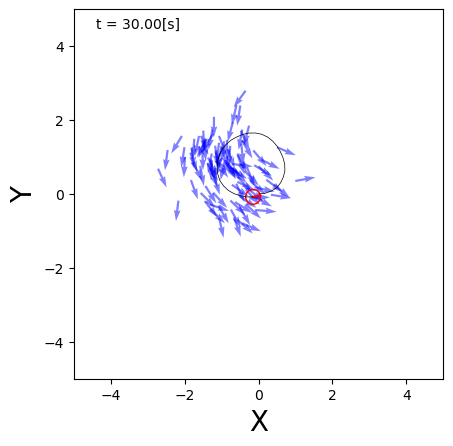

In [13]:
time_interval = 1.0
world = World(30, time_interval)
initial_pose = [0.0, 0.0, 0.0]
estimator = Mcl_(initial_pose, 100)
circling = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, estimator)
r = Robot_(initial_pose, sensor=nothing, agent=circling, color="red")
append(world, r)
draw(world)
showanim("test.mp4")

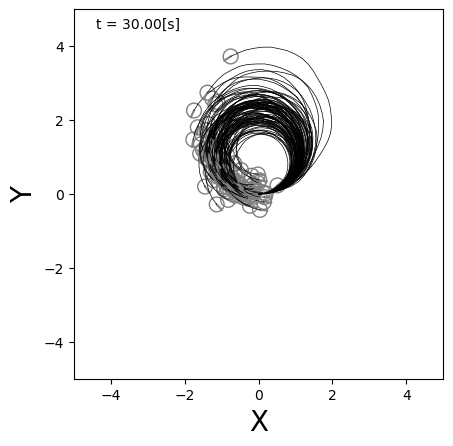

In [15]:
time_interval = 1.0
world = World(30, time_interval)
initial_pose = [0.0, 0.0, 0.0]
for i in 1:100
    r = Robot_(initial_pose, sensor=nothing, agent=Agent(0.2, 10.0/180*pi), color="gray")
    append(world, r)
end
draw(world)

In [ ]:
showanim("test.mp4")